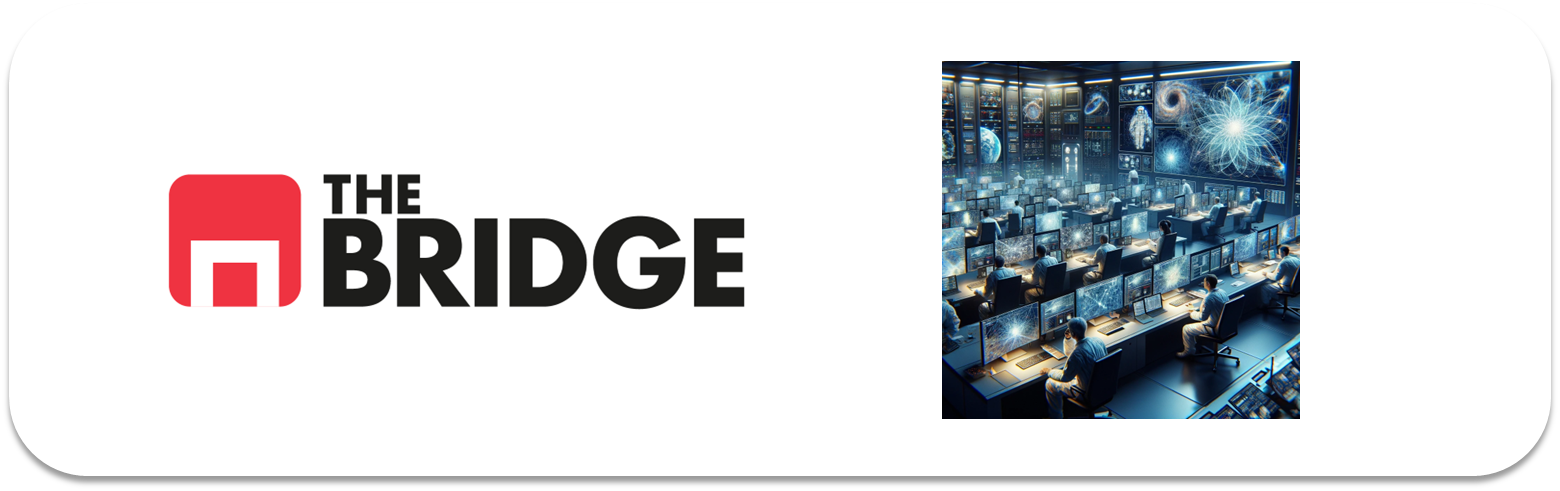

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

3. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

4. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



### Preparar los datos

In [2]:
ROOT_PATH = "./data/"
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (32, 32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [5]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (14034, 32, 32, 3)
Dimensiones de y_train: (14034,)
Dimensiones de X_test: (3000, 32, 32, 3)
Dimensiones de y_test: (3000,)


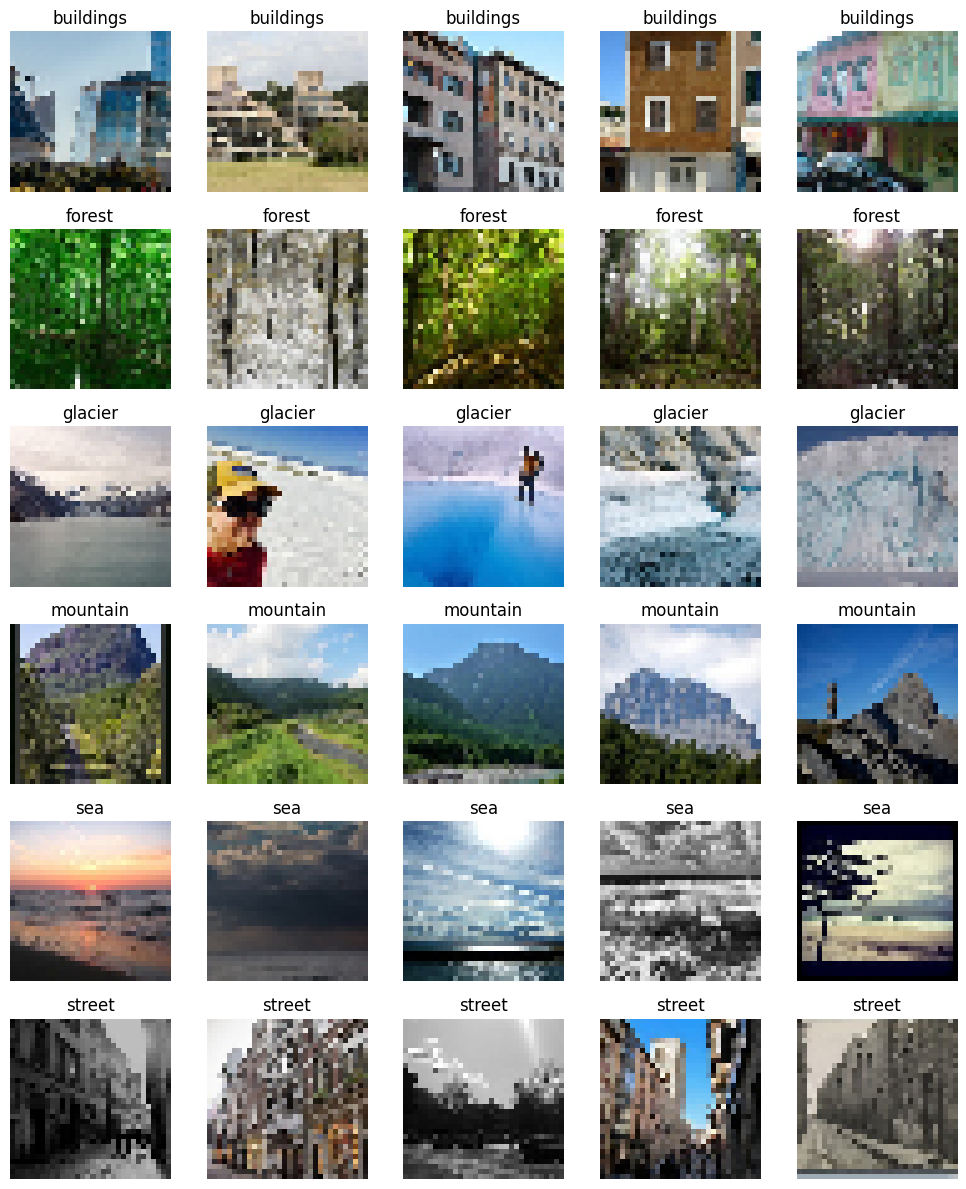

In [6]:
def visualize_samples(X, y, num_samples = 5):
    classes = np.unique(y)
    num_classes = len(classes)
    
    fig, axes = plt.subplots(num_classes, num_samples, figsize = (num_samples*2, num_classes*2))
    for i, cls in enumerate(classes):
        cls_indices = np.where(y == cls)[0]
        sample_indices = np.random.choice(cls_indices, num_samples, replace = False)
        
        for j, idx in enumerate(sample_indices):
            axes[i, j].imshow(X[idx])
            axes[i, j].set_title(cls)
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train)

In [7]:
X_train = X_train/255
X_test = X_test/255

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Transfer-Learning

In [9]:
base_model = MobileNetV2(input_shape = (32, 32, 3),
                         include_top = False,
                         weights = "imagenet")

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(64, activation = "relu"),
    Dense(6, activation = "softmax")
])

In [12]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
history = model.fit(X_train, 
                    y_train,                     
                    validation_split = 0.2,
                    batch_size = 32,
                    epochs = 10)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4477 - loss: 1.3837 - val_accuracy: 0.0620 - val_loss: 5.7300
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5714 - loss: 1.0618 - val_accuracy: 0.0648 - val_loss: 6.7340
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5908 - loss: 1.0238 - val_accuracy: 0.0477 - val_loss: 7.2949
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5917 - loss: 1.0005 - val_accuracy: 0.0477 - val_loss: 7.7285
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6008 - loss: 0.9818 - val_accuracy: 0.0506 - val_loss: 8.1301
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6127 - loss: 0.9668 - val_accuracy: 0.0488 - val_loss: 8.6115
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6122 - loss: 0.9669 - val_accuracy: 0.0445 - val_loss: 8.7291
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6100 - loss: 0.9470 - val_acc

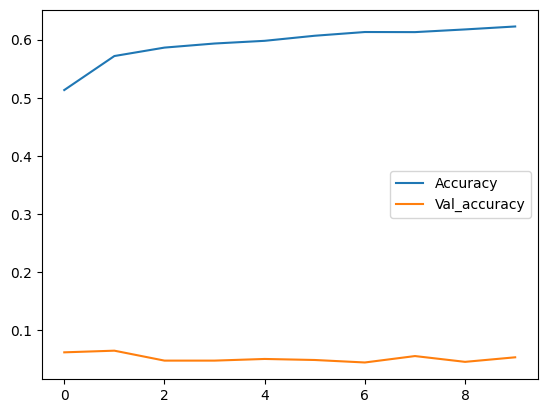

In [15]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df["accuracy"], label = "Accuracy")
plt.plot(history_df["val_accuracy"], label = "Val_accuracy")
plt.legend();

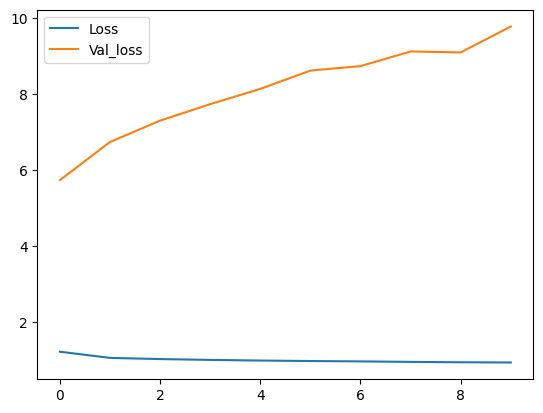

In [16]:
plt.plot(history_df["loss"], label = "Loss")
plt.plot(history_df["val_loss"], label = "Val_loss")
plt.legend();

In [17]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6439 - loss: 1.1152
test loss, test acc: [2.721564769744873, 0.4893333315849304]


In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [19]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.46      0.66      0.54       437
           1       0.67      0.89      0.77       474
           2       0.39      0.51      0.44       553
           3       0.45      0.50      0.47       525
           4       0.50      0.42      0.46       510
           5       0.00      0.00      0.00       501

    accuracy                           0.49      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.41      0.49      0.44      3000



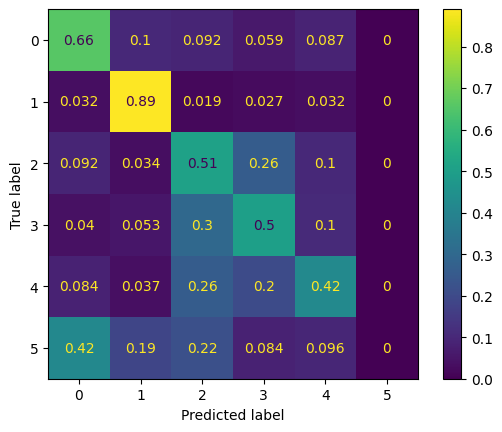

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, normalize = "true");

### Fine-Tuning

In [21]:
base_model = MobileNetV2(input_shape = (32, 32, 3),
                         include_top = False,
                         weights = "imagenet")

In [22]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(64, activation = "relu"),
    Dense(6, activation = "softmax")
])

In [23]:
model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [25]:
history = model.fit(X_train, 
                    y_train,                     
                    validation_split = 0.2,
                    batch_size = 32,
                    epochs = 10)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.4968 - loss: 1.4144 - val_accuracy: 0.0000e+00 - val_loss: 18.1253
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.7302 - loss: 0.7936 - val_accuracy: 0.0053 - val_loss: 7.0022
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.7400 - loss: 0.7442 - val_accuracy: 0.0000e+00 - val_loss: 27.4139
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.7771 - loss: 0.6706 - val_accuracy: 0.0292 - val_loss: 24.7130
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.7903 - loss: 0.6276 - val_accuracy: 0.0388 - val_loss: 23.5399
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.7891 - loss: 0.6223 - val_accuracy: 0.0631 - val_loss: 23.5582
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.7858 - loss: 0.6101 - val_accuracy: 0.0659 - val_loss: 14.9331
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7779 - l

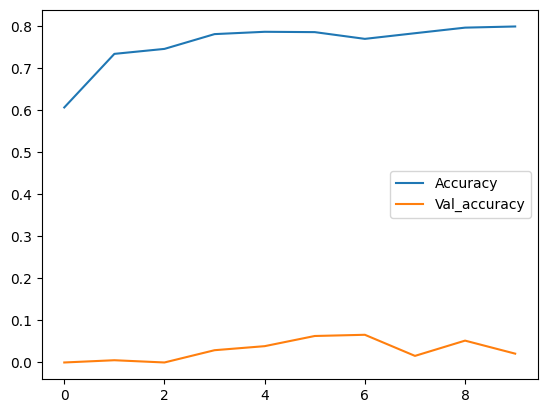

In [26]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df["accuracy"], label = "Accuracy")
plt.plot(history_df["val_accuracy"], label = "Val_accuracy")
plt.legend();

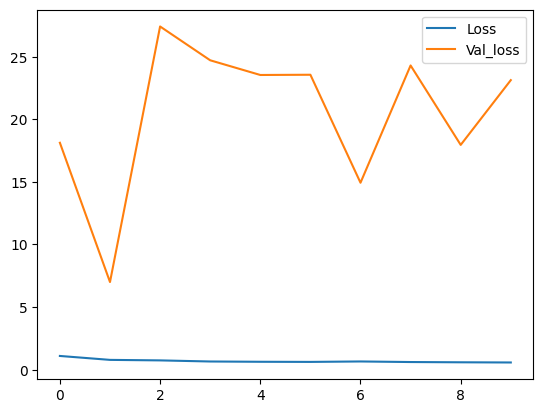

In [27]:
plt.plot(history_df["loss"], label = "Loss")
plt.plot(history_df["val_loss"], label = "Val_loss")
plt.legend();

In [28]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7547 - loss: 1.7845
test loss, test acc: [5.792855262756348, 0.5236666798591614]


In [29]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [30]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.53      0.78      0.64       437
           1       0.63      0.91      0.75       474
           2       0.41      0.95      0.57       553
           3       0.65      0.40      0.49       525
           4       0.94      0.12      0.22       510
           5       0.00      0.00      0.00       501

    accuracy                           0.52      3000
   macro avg       0.53      0.53      0.44      3000
weighted avg       0.53      0.52      0.44      3000



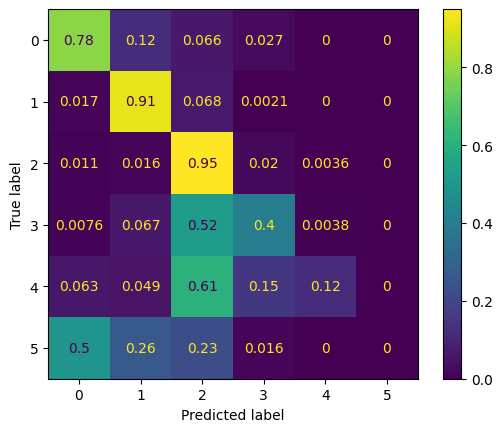

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, normalize = "true");